In [4]:
import numpy as np
import pandas as pd

from statsmodels.stats import proportion

import itertools
import re

import matplotlib.pyplot as plt
import seaborn as sbn
sbn.set_style('white')
sbn.set_palette('muted', 10)

%matplotlib inline

C:\Users\Ted\Anaconda\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [5]:
def define_words(alphabet, n):
    return [''.join(x) for x in itertools.product(alphabet, repeat=n)]

def replace_rare_base(s, rare_base='A'):
    return ''.join([c if (c is rare_base or c is '-') else 'X' for c in s ])

def get_nonrare_words(L, rare_base='A'):
    # This only works for non-dash sequences right now.
    n = len(L[0])
    
    words = define_words([rare_base, 'X'], n)
    counts = {w: 0 for w in words}
    res = {w: re.compile(w) for w in words}
    
    for s in L:
        mod_s = replace_rare_base(s, rare_base=rare_base)
        for w in words:
            # try using regexes? might not be faster than simple comps though...
            if res[w].search(mod_s):
                counts[w] +=1
    
    return counts

def get_pos_cts(L, letter_order=['C','T','G','A']):
    n = len(L[0])
    cts = pd.DataFrame(np.zeros((n, len(letter_order))), columns=letter_order)
    
    for i in range(n):
        v = [w[i] for w in L]
        for c in letter_order:
            cts[c][i] = v.count(c)
    
    return cts

In [6]:
words_3 = define_words(['A', 'X'], 3)
good_words_3 = ['AAA', 'XAA', 'XXA', 'XXX']
bad_words_3 = ['AAX', 'AXA', 'AXX', 'XAX']

words_5 = define_words(['A', 'X'], 5)
good_words_5 = ['AAAAA', 'XAAAA', 'XXAAA', 'XXXAA', 'XXXXA', 'XXXXX']
bad_words_5 = ['AAAAX', 'AAAXA', 'AAAXX', 'AAXAA', 'AAXAX', 'AAXXA', 'AAXXX', 'AXAAA',
               'AXAAX', 'AXAXA', 'AXAXX', 'AXXAA', 'AXXAX', 'AXXXA', 'AXXXX', 'XAAAX',
               'XAAXA', 'XAAXX', 'XAXAA', 'XAXAX', 'XAXXA', 'XAXXX', 'XXAAX', 'XXAXA',
               'XXAXX', 'XXXAX']

rev_good_words_5 = ['AAAAA', 'AAAAX', 'AAAXX', 'AAXXX', 'AXXXX', 'XXXXX']

# Run 3-site Replicates

In [7]:
data_path = """D:/Google Drive/To File - Research Docs/Screening/nextgenAnalysis/Data/2016_05_18/v2/word_files/"""

word_f_range_3 = range(20, 26+1)
t_range = np.array([0, 2, 5, 15, 30, 60, 120])
sample_idx = ['%im spike' % x for x in t_range]
sample_idx[-1] = 'No Spike'

data_3 = []
data_nodash_3 = []

for i in word_f_range_3:
    with open(data_path+'words_%i.txt' % i) as f:
        # Do full sequence loading
        data_3.append([line.strip() for line in f.readlines()])
        
        # Do no-dash, full extension stuff
        data_nodash_3.append([line for line in data_3[-1] if '-' not in line])
        
counts_3 = [get_nonrare_words(L) for L in data_nodash_3]
counts_3_df = pd.DataFrame()

counts_3_df['Time'] = t_range
for word in define_words(['A', 'X'], 3):
    counts_3_df[word] = [ct[word] for ct in counts_3]

rates_3_df = counts_3_df.div(counts_3_df[[c for c in counts_3_df.columns if c != 'Time']].sum(axis=1), axis=0)
rates_3_df.Time = counts_3_df.Time

ci_3_df = pd.DataFrame()
for w in words_3:
    lb, ub = proportion.proportion_confint(counts_3_df[w], counts_3_df.sum(axis=1))
    ci_3_df['%s_lb' % w] = lb
    ci_3_df['%s_ub' % w] = ub

#####################
# Replicate-specific code here
#####################

data_nodash_3_1 = data_nodash_3
counts_3_df_1 = counts_3_df
rates_3_df_1 = rates_3_df
ci_3_df_1 = ci_3_df

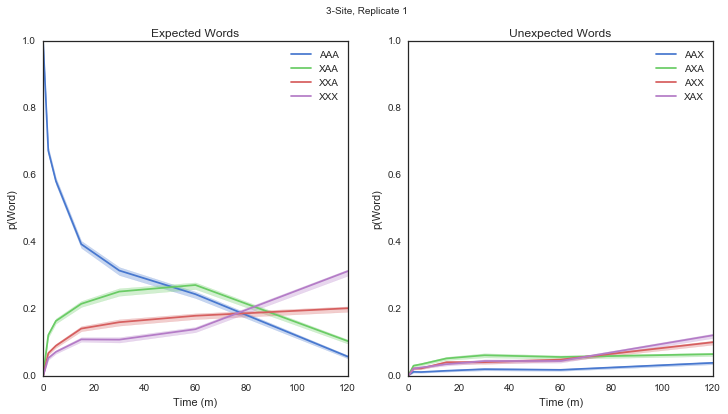

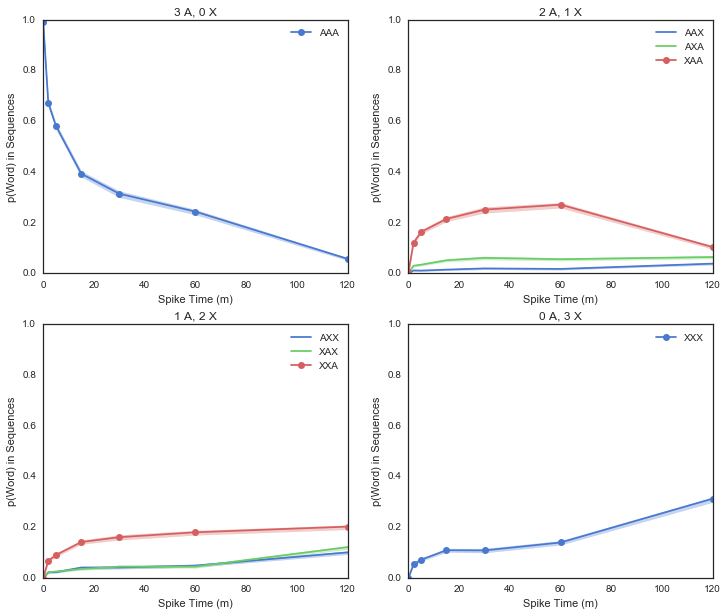

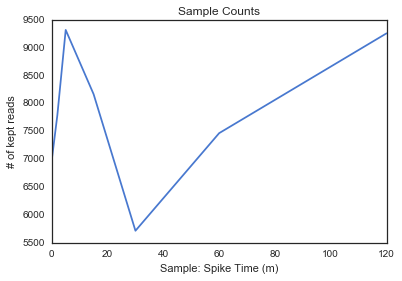

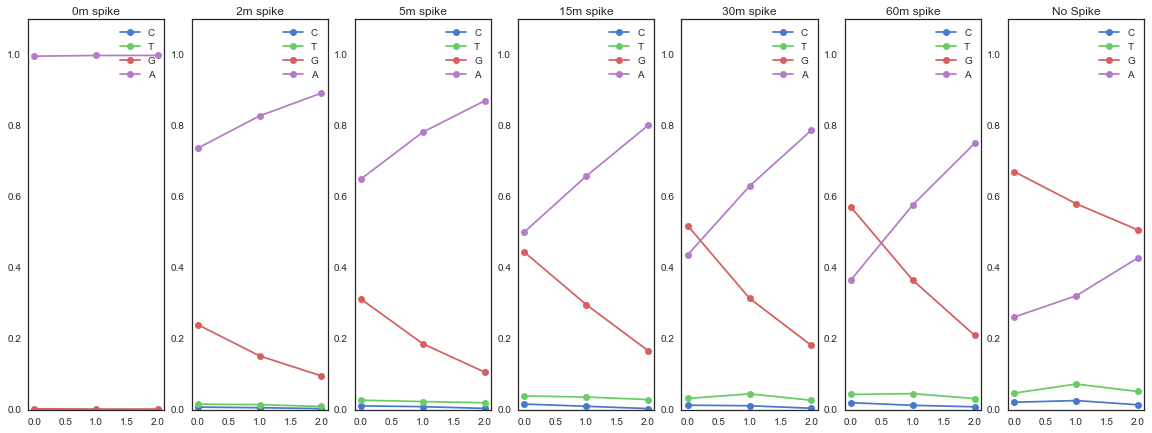

In [8]:
plt.figure(figsize=[12,6])
plt.suptitle('3-Site, Replicate 1')
plt.subplot(1,2,1)
plt.title('Expected Words')
for good_word in good_words_3:
    h = plt.plot(rates_3_df.Time, rates_3_df[good_word])
    plt.fill_between(rates_3_df.Time, 
                     ci_3_df['%s_lb' % good_word], ci_3_df['%s_ub' % good_word], 
                     color=h[0].get_color(), alpha=0.3)

plt.legend()
plt.axis([0, 120, 0, 1])
plt.xlabel('Time (m)')
plt.ylabel('p(Word)')

plt.subplot(1,2,2)
plt.title('Unexpected Words')
for bad_word in bad_words_3:
    h = plt.plot(rates_3_df.Time, rates_3_df[bad_word])
    plt.fill_between(rates_3_df.Time, 
                     ci_3_df['%s_lb' % bad_word], ci_3_df['%s_ub' % bad_word], 
                     color=h[0].get_color(), alpha=0.3)

plt.legend()
plt.axis([0, 120, 0, 1])
plt.xlabel('Time (m)')
plt.ylabel('p(Word)')

plt.savefig('3site_good_bad.png')

n_letters = 3

plt.figure(figsize=[12,10])
for i in range(0,n_letters+1):
    plt.subplot(2,2,n_letters+1-i)
    plt.title('%i A, %i X' % (i, n_letters-i))
    for w in words_3:
        if w.count('A') == i:
            if w in good_words_3:
                h = plt.plot(rates_3_df.Time, rates_3_df[w], 'o-')
            else:
                h = plt.plot(rates_3_df.Time, rates_3_df[w])
            plt.fill_between(rates_3_df.Time, 
                 ci_3_df['%s_lb' % w], ci_3_df['%s_ub' % w], 
                 color=h[0].get_color(), alpha=0.3)

    plt.legend()
    plt.axis([0, 120, 0, 1])
    plt.xlabel('Spike Time (m)')
    plt.ylabel('p(Word) in Sequences')

plt.savefig('3site_words.png')

plt.figure()
plt.title('Sample Counts')
plt.plot(rates_3_df.Time, counts_3_df[[c for c in counts_3_df.columns if c != 'Time']].sum(axis=1))
plt.xlabel('Sample: Spike Time (m)')
plt.ylabel('# of kept reads')

plt.figure(figsize=[20,7])
for i in range(len(data_nodash_3)):
    d = get_pos_cts(data_nodash_3[i])
    
    plt.subplot(1,7,i+1)
    for c in d.columns:
        plt.plot(d[c].div(d.sum(axis=1)), 'o-', label=c)
    plt.axis([-0.1, 2.1, 0, 1.1])
    plt.legend()
    plt.title(sample_idx[i])

plt.show()

In [9]:
data_path = """D:/Google Drive/To File - Research Docs/Screening/nextgenAnalysis/Data/2016_05_18/v2/word_files/"""

word_f_range_3 = range(27, 33+1)
t_range = np.array([0, 2, 5, 15, 30, 60, 120])
sample_idx = ['%im spike' % x for x in t_range]
sample_idx[-1] = 'No Spike'

data_3 = []
data_nodash_3 = []

for i in word_f_range_3:
    with open(data_path+'words_%i.txt' % i) as f:
        # Do full sequence loading
        data_3.append([line.strip() for line in f.readlines()])
        
        # Do no-dash, full extension stuff
        data_nodash_3.append([line for line in data_3[-1] if '-' not in line])
        
counts_3 = [get_nonrare_words(L) for L in data_nodash_3]
counts_3_df = pd.DataFrame()

counts_3_df['Time'] = t_range
for word in define_words(['A', 'X'], 3):
    counts_3_df[word] = [ct[word] for ct in counts_3]

rates_3_df = counts_3_df.div(counts_3_df[[c for c in counts_3_df.columns if c != 'Time']].sum(axis=1), axis=0)
rates_3_df.Time = counts_3_df.Time

ci_3_df = pd.DataFrame()
for w in words_3:
    lb, ub = proportion.proportion_confint(counts_3_df[w], counts_3_df.sum(axis=1))
    ci_3_df['%s_lb' % w] = lb
    ci_3_df['%s_ub' % w] = ub
    
#####################
# Replicate-specific code here
#####################

data_nodash_3_2 = data_nodash_3
counts_3_df_2 = counts_3_df
rates_3_df_2 = rates_3_df
ci_3_df_2 = ci_3_df

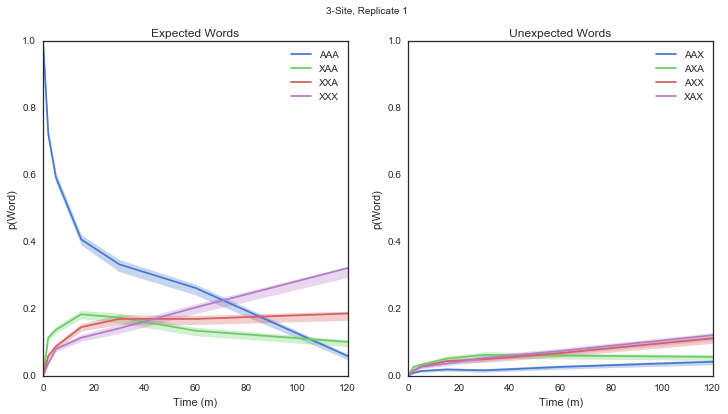

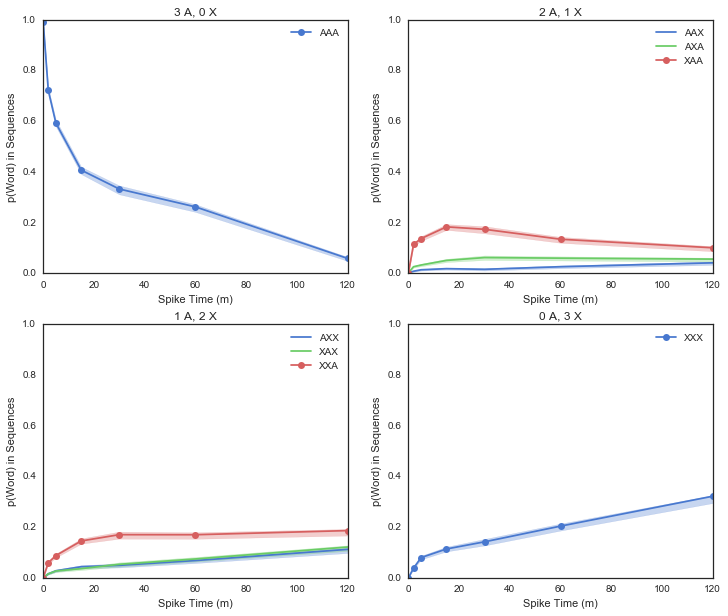

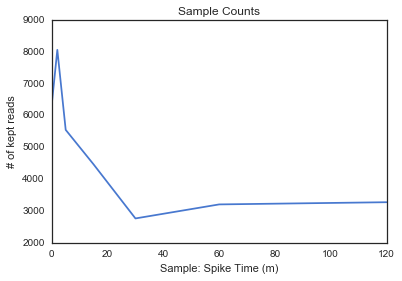

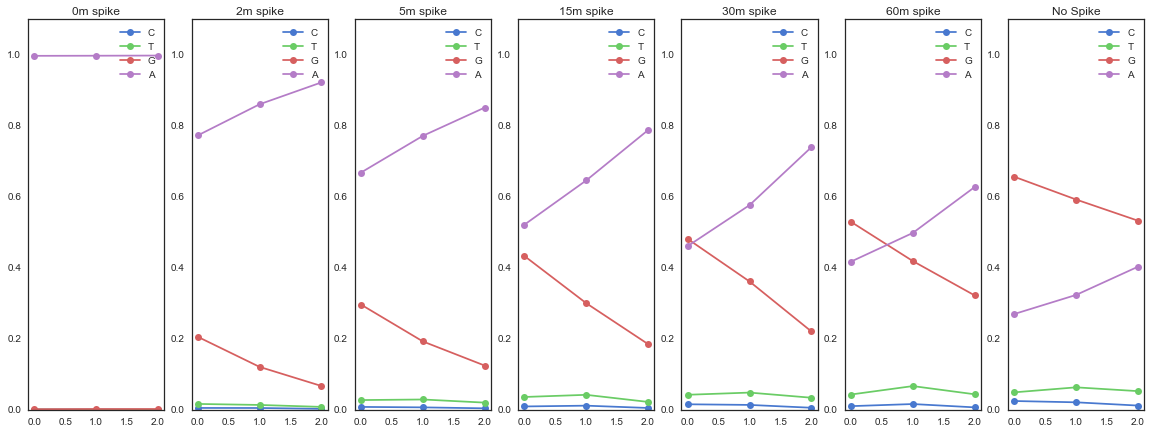

In [10]:
plt.figure(figsize=[12,6])
plt.suptitle('3-Site, Replicate 1')
plt.subplot(1,2,1)
plt.title('Expected Words')
for good_word in good_words_3:
    h = plt.plot(rates_3_df.Time, rates_3_df[good_word])
    plt.fill_between(rates_3_df.Time, 
                     ci_3_df['%s_lb' % good_word], ci_3_df['%s_ub' % good_word], 
                     color=h[0].get_color(), alpha=0.3)

plt.legend()
plt.axis([0, 120, 0, 1])
plt.xlabel('Time (m)')
plt.ylabel('p(Word)')

plt.subplot(1,2,2)
plt.title('Unexpected Words')
for bad_word in bad_words_3:
    h = plt.plot(rates_3_df.Time, rates_3_df[bad_word])
    plt.fill_between(rates_3_df.Time, 
                     ci_3_df['%s_lb' % bad_word], ci_3_df['%s_ub' % bad_word], 
                     color=h[0].get_color(), alpha=0.3)

plt.legend()
plt.axis([0, 120, 0, 1])
plt.xlabel('Time (m)')
plt.ylabel('p(Word)')

plt.savefig('3site_good_bad.png')

n_letters = 3

plt.figure(figsize=[12,10])
for i in range(0,n_letters+1):
    plt.subplot(2,2,n_letters+1-i)
    plt.title('%i A, %i X' % (i, n_letters-i))
    for w in words_3:
        if w.count('A') == i:
            if w in good_words_3:
                h = plt.plot(rates_3_df.Time, rates_3_df[w], 'o-')
            else:
                h = plt.plot(rates_3_df.Time, rates_3_df[w])
            plt.fill_between(rates_3_df.Time, 
                 ci_3_df['%s_lb' % w], ci_3_df['%s_ub' % w], 
                 color=h[0].get_color(), alpha=0.3)

    plt.legend()
    plt.axis([0, 120, 0, 1])
    plt.xlabel('Spike Time (m)')
    plt.ylabel('p(Word) in Sequences')

plt.savefig('3site_words.png')

plt.figure()
plt.title('Sample Counts')
plt.plot(rates_3_df.Time, counts_3_df[[c for c in counts_3_df.columns if c != 'Time']].sum(axis=1))
plt.xlabel('Sample: Spike Time (m)')
plt.ylabel('# of kept reads')

plt.figure(figsize=[20,7])
for i in range(len(data_nodash_3)):
    d = get_pos_cts(data_nodash_3[i])
    
    plt.subplot(1,7,i+1)
    for c in d.columns:
        plt.plot(d[c].div(d.sum(axis=1)), 'o-', label=c)
    plt.axis([-0.1, 2.1, 0, 1.1])
    plt.legend()
    plt.title(sample_idx[i])

plt.show()

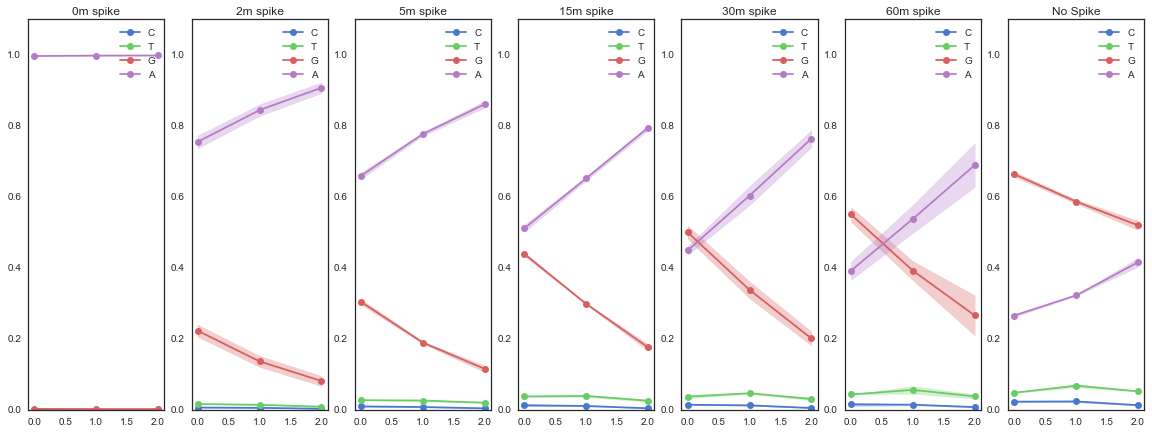

In [12]:
plt.figure(figsize=[20,7])
for i in range(len(data_nodash_3)):
    d = get_pos_cts(data_nodash_3_1[i])
    d2 = get_pos_cts(data_nodash_3_2[i])
    
    plt.subplot(1,7,i+1)
    for c in d.columns:
        mat = np.array([d[c].div(d.sum(axis=1)), d2[c].div(d2.sum(axis=1))])
        y = np.mean(mat, axis=0)
        std = np.std(mat, axis=0)
        h = plt.plot(y, 'o-', label=c)
        plt.fill_between(range(len(y)), y-std, y+std, color=h[0].get_color(), alpha = 0.3)
    plt.axis([-0.1, 2.1, 0, 1.1])
    plt.legend()
    plt.title(sample_idx[i])
    
plt.savefig('3_site_avg_site.png')

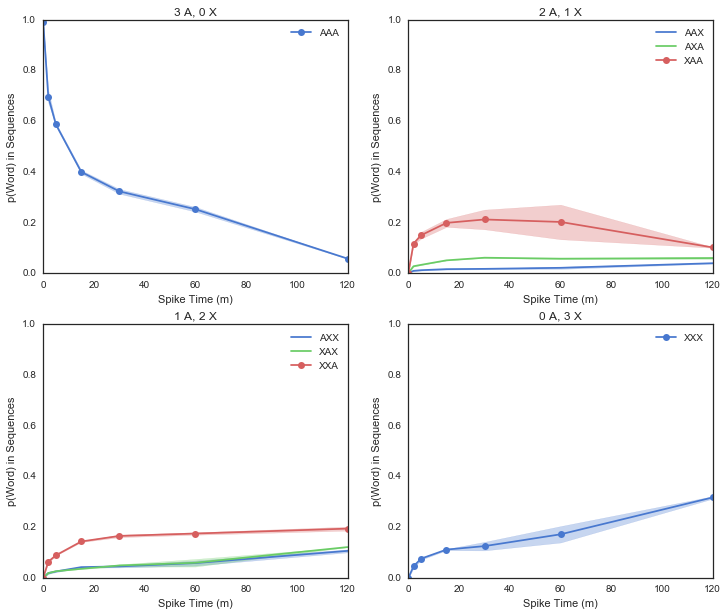

In [14]:
n_letters = 3

plt.figure(figsize=[12,10])
for i in range(0,n_letters+1):
    plt.subplot(2,2,n_letters+1-i)
    plt.title('%i A, %i X' % (i, n_letters-i))
    for w in words_3:
        if w.count('A') == i:
            mat = np.array([rates_3_df_1[w], rates_3_df_2[w]])
            y = np.mean(mat, axis=0)
            std = np.std(mat, axis=0)
            if w in good_words_3:
                h = plt.plot(rates_3_df.Time, y, 'o-', label=w)
            else:
                h = plt.plot(rates_3_df.Time, y, label=w)
            plt.fill_between(rates_3_df.Time, 
                 y-std, y+std, 
                 color=h[0].get_color(), alpha=0.3)

    plt.legend()
    plt.axis([0, 120, 0, 1])
    plt.xlabel('Spike Time (m)')
    plt.ylabel('p(Word) in Sequences')

plt.savefig('words_3_site_avg.svg')

# 5-Site Replicates

In [13]:
data_path = """D:/Google Drive/To File - Research Docs/Screening/nextgenAnalysis/Data/2016_05_18/v2/del_word_files/"""

word_f_range_5 = range(34, 40+1)
t_range = np.array([0, 2, 5, 15, 30, 60, 120])

data_5 = []
data_nodash_5 = []

for i in word_f_range_5:
    with open(data_path+'words_del%i.txt' % i) as f:
        # Do full sequence loading
        data_5.append([line.strip() for line in f.readlines()])
        
        # Do no-dash, full extension stuff
        data_nodash_5.append([line for line in data_5[-1] if '-' not in line])

counts_5 = [get_nonrare_words(L) for L in data_nodash_5]
counts_5_df = pd.DataFrame()

counts_5_df['Time'] = t_range
for word in define_words(['A', 'X'], 5):
    counts_5_df[word] = [ct[word] for ct in counts_5]

rates_5_df = counts_5_df.div(counts_5_df[[c for c in counts_5_df.columns if c != 'Time']].sum(axis=1), axis=0)
rates_5_df.Time = counts_5_df.Time

ci_5_df = pd.DataFrame()
for w in words_5:
    lb, ub = proportion.proportion_confint(counts_5_df[w], counts_5_df.sum(axis=1))
    ci_5_df['%s_lb' % w] = lb
    ci_5_df['%s_ub' % w] = ub
    
    
#####################
# Replicate-specific code here
#####################

data_nodash_5_1 = data_nodash_5
counts_5_df_1 = counts_5_df
rates_5_df_1 = rates_5_df
ci_5_df_1 = ci_5_df

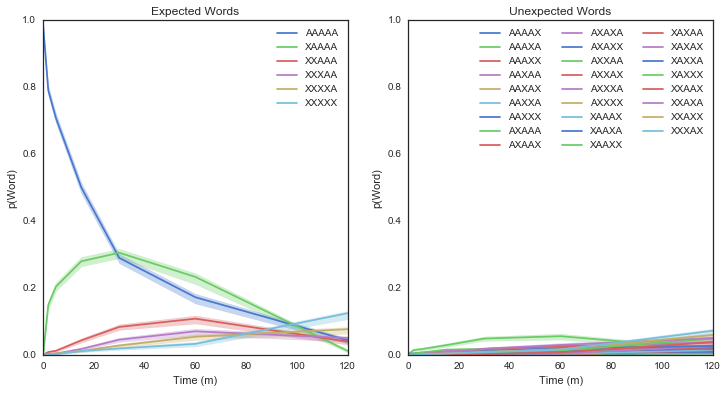

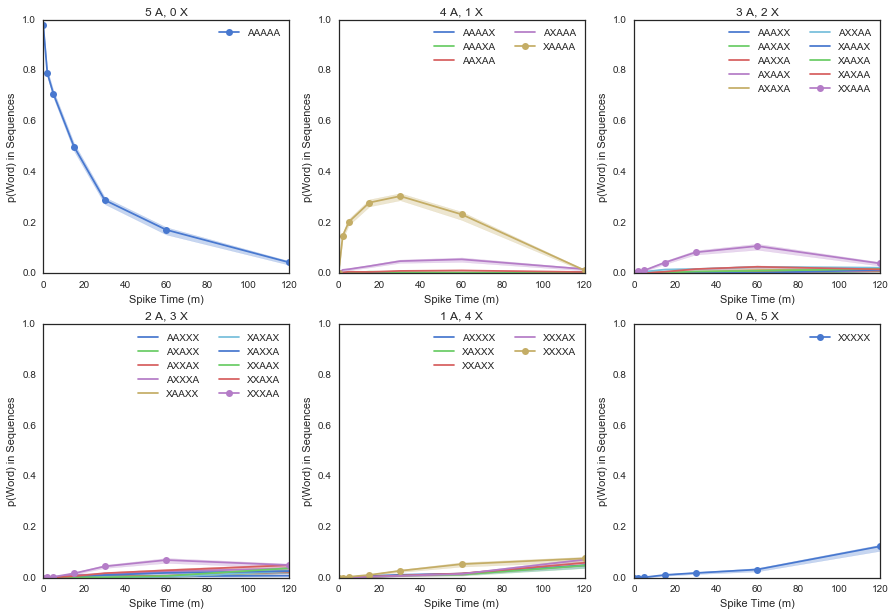

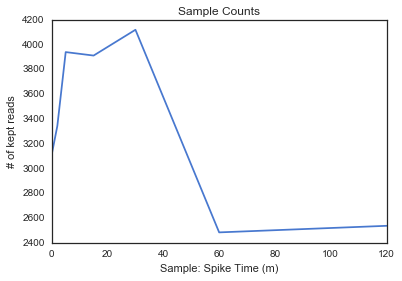

In [14]:
plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
plt.title('Expected Words')
for good_word in good_words_5:
    h = plt.plot(rates_5_df.Time, rates_5_df[good_word])
    plt.fill_between(rates_5_df.Time, 
                     ci_5_df['%s_lb' % good_word], ci_5_df['%s_ub' % good_word], 
                     color=h[0].get_color(), alpha=0.3)

plt.legend()
plt.axis([0, 120, 0, 1])
plt.xlabel('Time (m)')
plt.ylabel('p(Word)')

plt.subplot(1,2,2)
plt.title('Unexpected Words')
for bad_word in bad_words_5:
    h = plt.plot(rates_5_df.Time, rates_5_df[bad_word])
    plt.fill_between(rates_5_df.Time, 
                     ci_5_df['%s_lb' % bad_word], ci_5_df['%s_ub' % bad_word], 
                     color=h[0].get_color(), alpha=0.3)

plt.legend(ncol=3)
plt.axis([0, 120, 0, 1])
plt.xlabel('Time (m)')
plt.ylabel('p(Word)')

plt.savefig('5site_good_bad.png')

plt.figure(figsize=[15,10])
for i in range(0,5+1):
    plt.subplot(2,3,6-i)
    plt.title('%i A, %i X' % (i, 5-i))
    for w in words_5:
        if w.count('A') == i:
            if w in good_words_5:
                h = plt.plot(rates_5_df.Time, rates_5_df[w], 'o-')
            else:
                h = plt.plot(rates_5_df.Time, rates_5_df[w])
            plt.fill_between(rates_5_df.Time, 
                 ci_5_df['%s_lb' % w], ci_5_df['%s_ub' % w], 
                 color=h[0].get_color(), alpha=0.3)

    plt.legend(ncol=2)
    plt.axis([0, 120, 0, 1])
    plt.xlabel('Spike Time (m)')
    plt.ylabel('p(Word) in Sequences')
    
plt.savefig('5site_words.png')

plt.figure()
plt.title('Sample Counts')
plt.plot(rates_5_df.Time, counts_5_df[[c for c in counts_5_df.columns if c != 'Time']].sum(axis=1))
plt.xlabel('Sample: Spike Time (m)')
plt.ylabel('# of kept reads')

plt.show()

In [15]:
data_path = """D:/Google Drive/To File - Research Docs/Screening/nextgenAnalysis/Data/2016_05_18/v2/del_word_files/"""

word_f_range_5 = range(41, 47+1)
t_range = np.array([0, 2, 5, 15, 30, 60, 120])

data_5 = []
data_nodash_5 = []

for i in word_f_range_5:
    with open(data_path+'words_del%i.txt' % i) as f:
        # Do full sequence loading
        data_5.append([line.strip() for line in f.readlines()])
        
        # Do no-dash, full extension stuff
        data_nodash_5.append([line for line in data_5[-1] if '-' not in line])

counts_5 = [get_nonrare_words(L) for L in data_nodash_5]
counts_5_df = pd.DataFrame()

counts_5_df['Time'] = t_range
for word in define_words(['A', 'X'], 5):
    counts_5_df[word] = [ct[word] for ct in counts_5]

rates_5_df = counts_5_df.div(counts_5_df[[c for c in counts_5_df.columns if c != 'Time']].sum(axis=1), axis=0)
rates_5_df.Time = counts_5_df.Time

ci_5_df = pd.DataFrame()
for w in words_5:
    lb, ub = proportion.proportion_confint(counts_5_df[w], counts_5_df.sum(axis=1))
    ci_5_df['%s_lb' % w] = lb
    ci_5_df['%s_ub' % w] = ub
    
#####################
# Replicate-specific code here
#####################

data_nodash_5_2 = data_nodash_5
counts_5_df_2 = counts_5_df
rates_5_df_2 = rates_5_df
ci_5_df_2 = ci_5_df

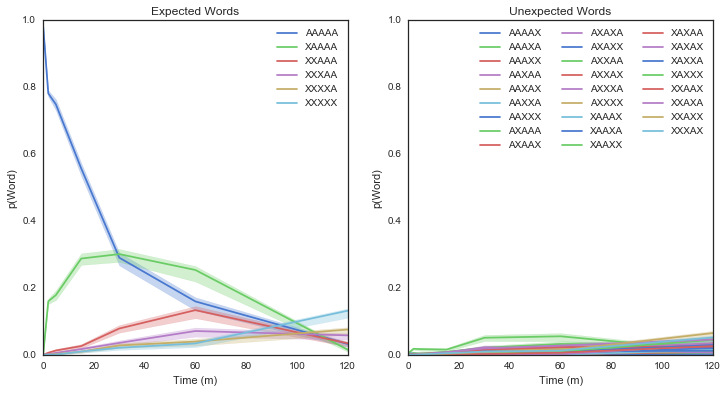

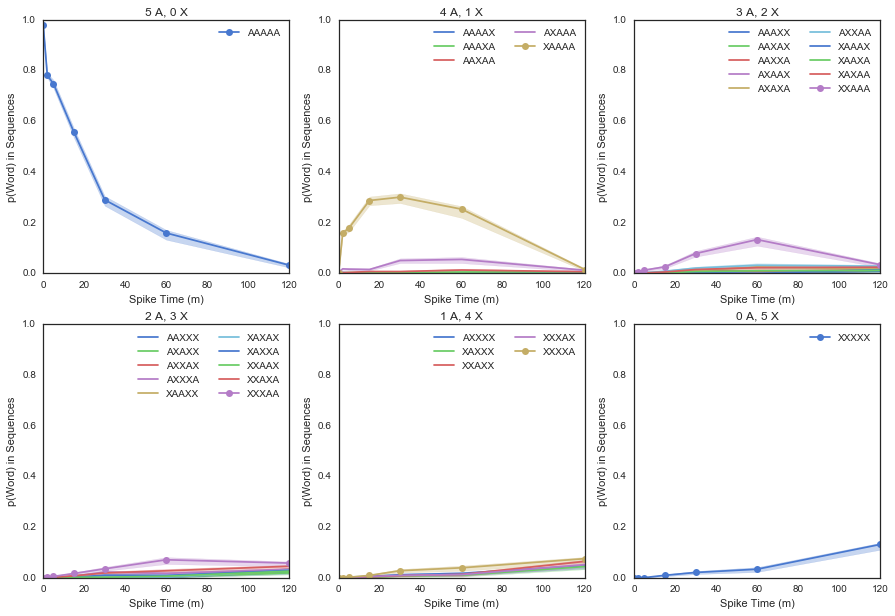

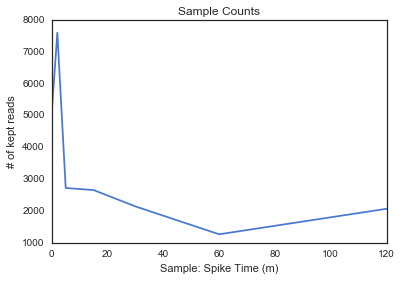

In [16]:
plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
plt.title('Expected Words')
for good_word in good_words_5:
    h = plt.plot(rates_5_df.Time, rates_5_df[good_word])
    plt.fill_between(rates_5_df.Time, 
                     ci_5_df['%s_lb' % good_word], ci_5_df['%s_ub' % good_word], 
                     color=h[0].get_color(), alpha=0.3)

plt.legend()
plt.axis([0, 120, 0, 1])
plt.xlabel('Time (m)')
plt.ylabel('p(Word)')

plt.subplot(1,2,2)
plt.title('Unexpected Words')
for bad_word in bad_words_5:
    h = plt.plot(rates_5_df.Time, rates_5_df[bad_word])
    plt.fill_between(rates_5_df.Time, 
                     ci_5_df['%s_lb' % bad_word], ci_5_df['%s_ub' % bad_word], 
                     color=h[0].get_color(), alpha=0.3)

plt.legend(ncol=3)
plt.axis([0, 120, 0, 1])
plt.xlabel('Time (m)')
plt.ylabel('p(Word)')

plt.savefig('5site_good_bad.png')

plt.figure(figsize=[15,10])
for i in range(0,5+1):
    plt.subplot(2,3,6-i)
    plt.title('%i A, %i X' % (i, 5-i))
    for w in words_5:
        if w.count('A') == i:
            if w in good_words_5:
                h = plt.plot(rates_5_df.Time, rates_5_df[w], 'o-')
            else:
                h = plt.plot(rates_5_df.Time, rates_5_df[w])
            plt.fill_between(rates_5_df.Time, 
                 ci_5_df['%s_lb' % w], ci_5_df['%s_ub' % w], 
                 color=h[0].get_color(), alpha=0.3)

    plt.legend(ncol=2)
    plt.axis([0, 120, 0, 1])
    plt.xlabel('Spike Time (m)')
    plt.ylabel('p(Word) in Sequences')
    
plt.savefig('5site_words.png')

plt.figure()
plt.title('Sample Counts')
plt.plot(rates_5_df.Time, counts_5_df[[c for c in counts_5_df.columns if c != 'Time']].sum(axis=1))
plt.xlabel('Sample: Spike Time (m)')
plt.ylabel('# of kept reads')

plt.show()

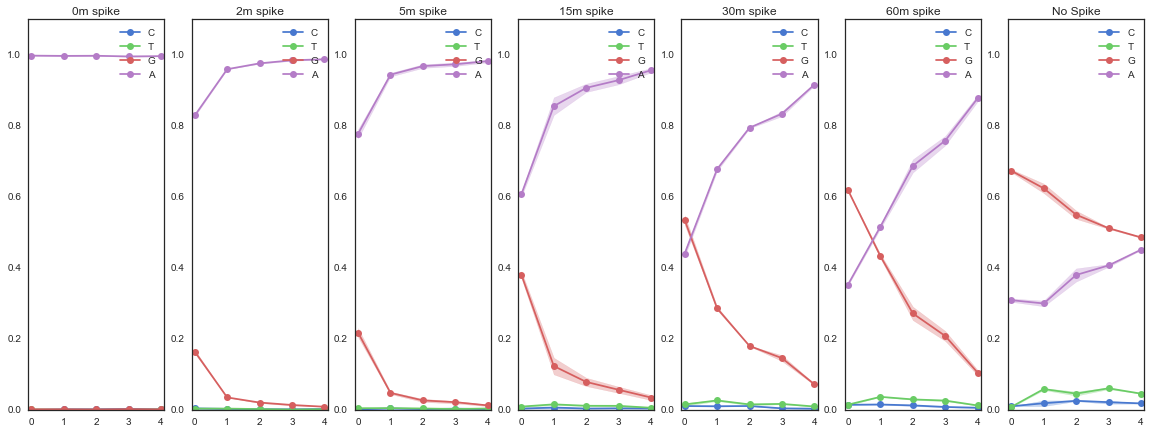

In [18]:
plt.figure(figsize=[20,7])
for i in range(len(data_nodash_5)):
    d = get_pos_cts(data_nodash_5_1[i])
    d2 = get_pos_cts(data_nodash_5_2[i])
    
    plt.subplot(1,7,i+1)
    for c in d.columns:
        mat = np.array([d[c].div(d.sum(axis=1)), d2[c].div(d2.sum(axis=1))])
        y = np.mean(mat, axis=0)
        std = np.std(mat, axis=0)
        h = plt.plot(y, 'o-', label=c)
        plt.fill_between(range(len(y)), y-std, y+std, color=h[0].get_color(), alpha = 0.3)
    plt.axis([-0.1, 4.1, 0, 1.1])
    plt.legend()
    plt.title(sample_idx[i])
    
plt.savefig('5_site_avg_site.PNG')

# 5-Site, Long Extension Replicates

In [76]:
data_path = """D:/Google Drive/To File - Research Docs/Screening/nextgenAnalysis/Data/2016_05_18/v2/del_word_files/"""

word_f_range_5 = range(48, 55+1)
t_range = np.array([0, 0.5, 1, 2, 3, 4, 6, 7])
sample_idx = ['%ih Spike' % x for x in t_range]

data_5 = []
data_nodash_5 = []

for i in word_f_range_5:
    with open(data_path+'words_del%i.txt' % i) as f:
        # Do full sequence loading
        data_5.append([line.strip() for line in f.readlines()])
        
        # Do no-dash, full extension stuff
        data_nodash_5.append([line for line in data_5[-1] if '-' not in line])

counts_5 = [get_nonrare_words(L) for L in data_nodash_5]
counts_5_df = pd.DataFrame()

counts_5_df['Time'] = t_range
for word in define_words(['A', 'X'], 5):
    counts_5_df[word] = [ct[word] for ct in counts_5]

rates_5_df = counts_5_df.div(counts_5_df[[c for c in counts_5_df.columns if c != 'Time']].sum(axis=1), axis=0)
rates_5_df.Time = counts_5_df.Time

ci_5_df = pd.DataFrame()
for w in words_5:
    lb, ub = proportion.proportion_confint(counts_5_df[w], counts_5_df.sum(axis=1))
    ci_5_df['%s_lb' % w] = lb
    ci_5_df['%s_ub' % w] = ub
    
#####################
# Replicate-specific code here
#####################

data_nodash_5_1 = data_nodash_5
counts_5_df_1 = counts_5_df
rates_5_df_1 = rates_5_df
ci_5_df_1 = ci_5_df

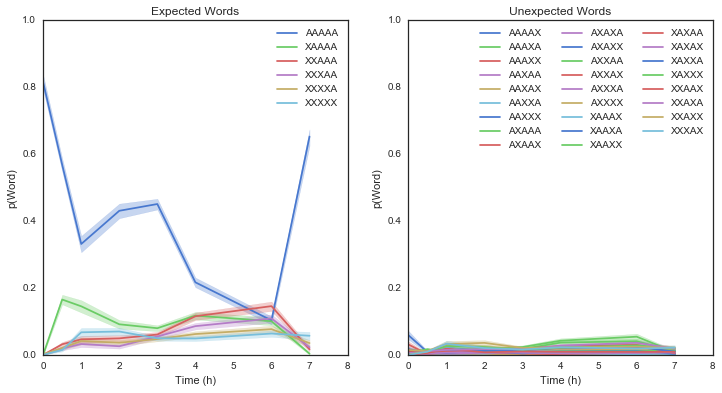

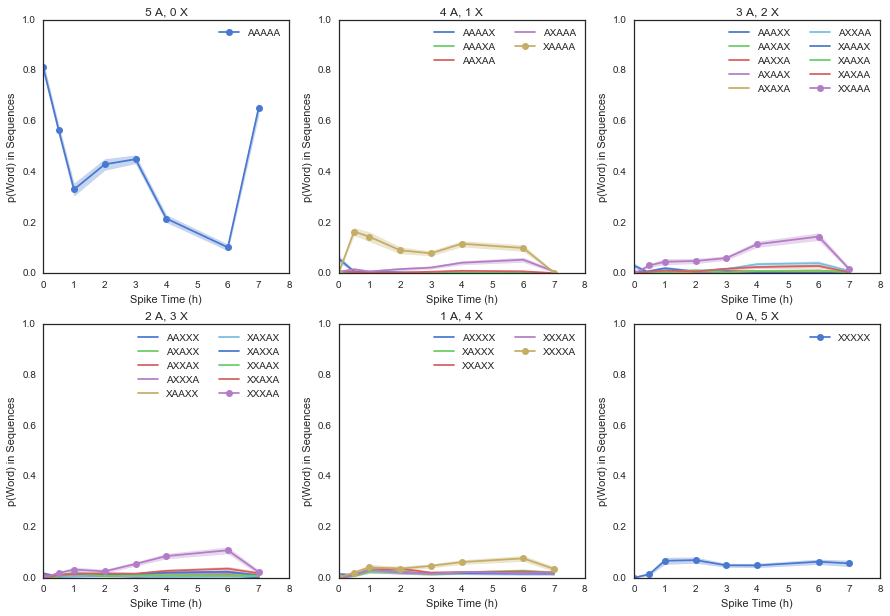

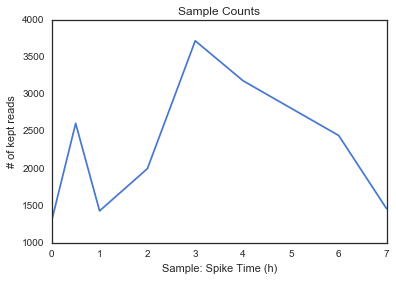

In [77]:
plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
plt.title('Expected Words')
for good_word in good_words_5:
    h = plt.plot(rates_5_df.Time, rates_5_df[good_word])
    plt.fill_between(rates_5_df.Time, 
                     ci_5_df['%s_lb' % good_word], ci_5_df['%s_ub' % good_word], 
                     color=h[0].get_color(), alpha=0.3)

plt.legend()
plt.axis([0, 8, 0, 1])
plt.xlabel('Time (h)')
plt.ylabel('p(Word)')

plt.subplot(1,2,2)
plt.title('Unexpected Words')
for bad_word in bad_words_5:
    h = plt.plot(rates_5_df.Time, rates_5_df[bad_word])
    plt.fill_between(rates_5_df.Time, 
                     ci_5_df['%s_lb' % bad_word], ci_5_df['%s_ub' % bad_word], 
                     color=h[0].get_color(), alpha=0.3)

plt.legend(ncol=3)
plt.axis([0, 8, 0, 1])
plt.xlabel('Time (h)')
plt.ylabel('p(Word)')

plt.savefig('5site_good_bad.png')

plt.figure(figsize=[15,10])
for i in range(0,5+1):
    plt.subplot(2,3,6-i)
    plt.title('%i A, %i X' % (i, 5-i))
    for w in words_5:
        if w.count('A') == i:
            if w in good_words_5:
                h = plt.plot(rates_5_df.Time, rates_5_df[w], 'o-')
            else:
                h = plt.plot(rates_5_df.Time, rates_5_df[w])
            plt.fill_between(rates_5_df.Time, 
                 ci_5_df['%s_lb' % w], ci_5_df['%s_ub' % w], 
                 color=h[0].get_color(), alpha=0.3)

    plt.legend(ncol=2)
    plt.axis([0, 8, 0, 1])
    plt.xlabel('Spike Time (h)')
    plt.ylabel('p(Word) in Sequences')
    
plt.savefig('5site_words.png')

plt.figure()
plt.title('Sample Counts')
plt.plot(rates_5_df.Time, counts_5_df[[c for c in counts_5_df.columns if c != 'Time']].sum(axis=1))
plt.xlabel('Sample: Spike Time (h)')
plt.ylabel('# of kept reads')

plt.show()

In [78]:
data_path = """D:/Google Drive/To File - Research Docs/Screening/nextgenAnalysis/Data/2016_05_18/v2/del_word_files/"""

word_f_range_5 = range(56, 63+1)
t_range = np.array([0, 0.5, 1, 2, 3, 4, 6, 7])

data_5 = []
data_nodash_5 = []

for i in word_f_range_5:
    with open(data_path+'words_del%i.txt' % i) as f:
        # Do full sequence loading
        data_5.append([line.strip() for line in f.readlines()])
        
        # Do no-dash, full extension stuff
        data_nodash_5.append([line for line in data_5[-1] if '-' not in line])

counts_5 = [get_nonrare_words(L) for L in data_nodash_5]
counts_5_df = pd.DataFrame()

counts_5_df['Time'] = t_range
for word in define_words(['A', 'X'], 5):
    counts_5_df[word] = [ct[word] for ct in counts_5]

rates_5_df = counts_5_df.div(counts_5_df[[c for c in counts_5_df.columns if c != 'Time']].sum(axis=1), axis=0)
rates_5_df.Time = counts_5_df.Time

ci_5_df = pd.DataFrame()
for w in words_5:
    lb, ub = proportion.proportion_confint(counts_5_df[w], counts_5_df.sum(axis=1))
    ci_5_df['%s_lb' % w] = lb
    ci_5_df['%s_ub' % w] = ub
    
#####################
# Replicate-specific code here
#####################

data_nodash_5_2 = data_nodash_5
counts_5_df_2 = counts_5_df
rates_5_df_2 = rates_5_df
ci_5_df_2 = ci_5_df

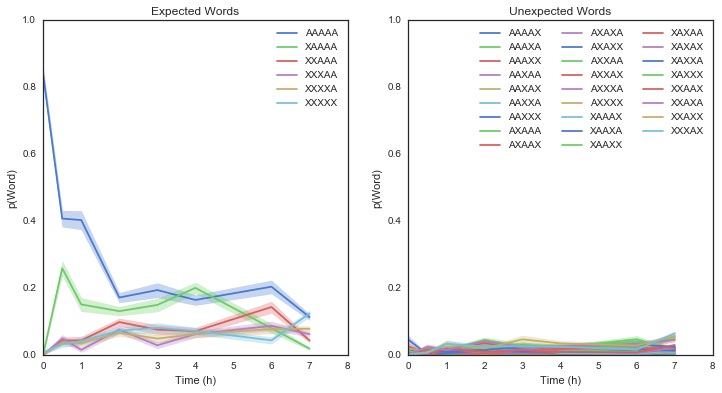

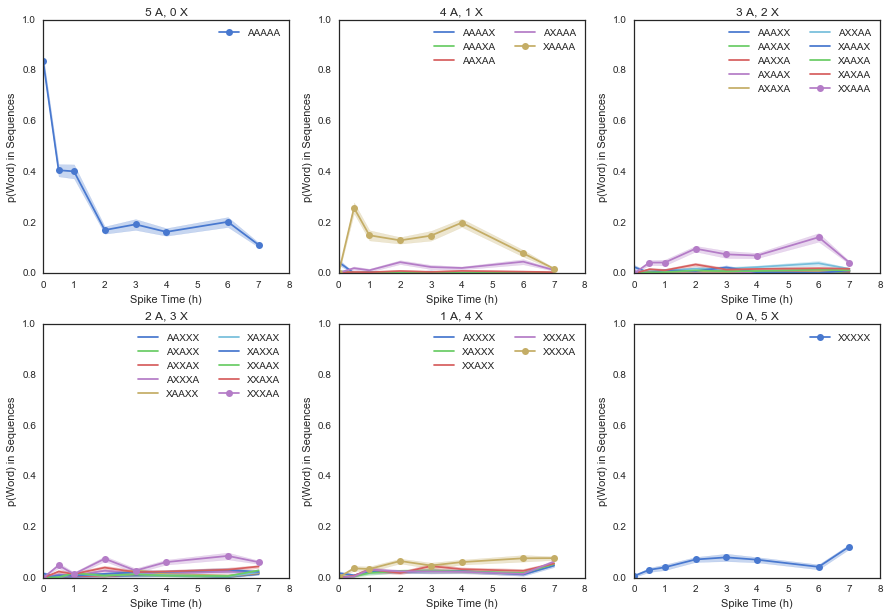

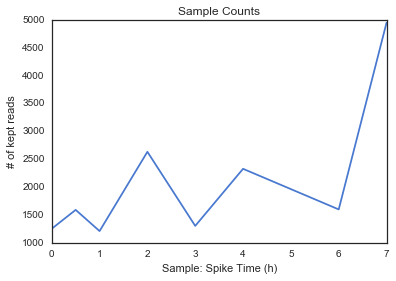

In [79]:
plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
plt.title('Expected Words')
for good_word in good_words_5:
    h = plt.plot(rates_5_df.Time, rates_5_df[good_word])
    plt.fill_between(rates_5_df.Time, 
                     ci_5_df['%s_lb' % good_word], ci_5_df['%s_ub' % good_word], 
                     color=h[0].get_color(), alpha=0.3)

plt.legend()
plt.axis([0, 8, 0, 1])
plt.xlabel('Time (h)')
plt.ylabel('p(Word)')

plt.subplot(1,2,2)
plt.title('Unexpected Words')
for bad_word in bad_words_5:
    h = plt.plot(rates_5_df.Time, rates_5_df[bad_word])
    plt.fill_between(rates_5_df.Time, 
                     ci_5_df['%s_lb' % bad_word], ci_5_df['%s_ub' % bad_word], 
                     color=h[0].get_color(), alpha=0.3)

plt.legend(ncol=3)
plt.axis([0, 8, 0, 1])
plt.xlabel('Time (h)')
plt.ylabel('p(Word)')

plt.savefig('5site_good_bad.png')

plt.figure(figsize=[15,10])
for i in range(0,5+1):
    plt.subplot(2,3,6-i)
    plt.title('%i A, %i X' % (i, 5-i))
    for w in words_5:
        if w.count('A') == i:
            if w in good_words_5:
                h = plt.plot(rates_5_df.Time, rates_5_df[w], 'o-')
            else:
                h = plt.plot(rates_5_df.Time, rates_5_df[w])
            plt.fill_between(rates_5_df.Time, 
                 ci_5_df['%s_lb' % w], ci_5_df['%s_ub' % w], 
                 color=h[0].get_color(), alpha=0.3)

    plt.legend(ncol=2)
    plt.axis([0, 8, 0, 1])
    plt.xlabel('Spike Time (h)')
    plt.ylabel('p(Word) in Sequences')
    
plt.savefig('5site_words.png')

plt.figure()
plt.title('Sample Counts')
plt.plot(rates_5_df.Time, counts_5_df[[c for c in counts_5_df.columns if c != 'Time']].sum(axis=1))
plt.xlabel('Sample: Spike Time (h)')
plt.ylabel('# of kept reads')

plt.show()

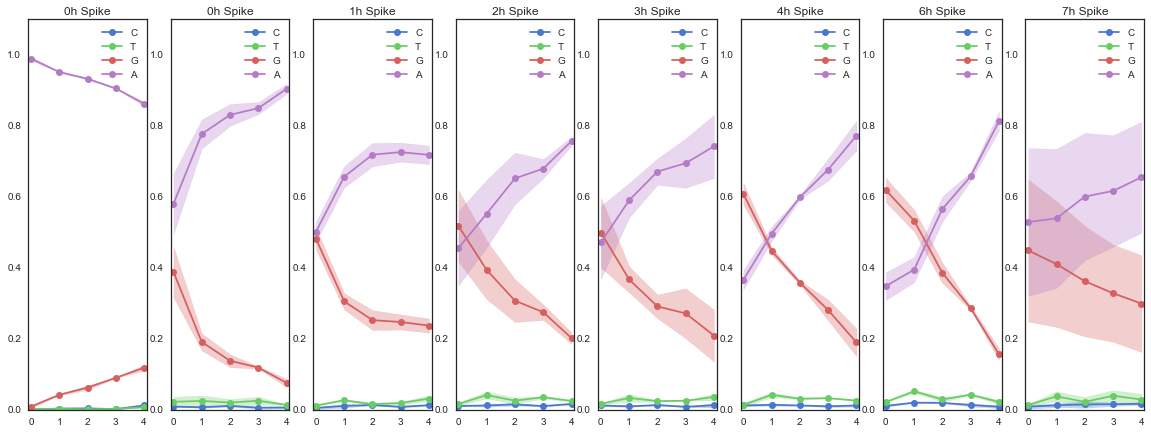

In [81]:
plt.figure(figsize=[20,7])
for i in range(len(data_nodash_5)):
    d = get_pos_cts(data_nodash_5_1[i])
    d2 = get_pos_cts(data_nodash_5_2[i])
    
    plt.subplot(1,8,i+1)
    for c in d.columns:
        mat = np.array([d[c].div(d.sum(axis=1)), d2[c].div(d2.sum(axis=1))])
        y = np.mean(mat, axis=0)
        std = np.std(mat, axis=0)
        h = plt.plot(y, 'o-', label=c)
        plt.fill_between(range(len(y)), y-std, y+std, color=h[0].get_color(), alpha = 0.3)
    plt.axis([-0.1, 4.1, 0, 1.1])
    plt.legend()
    plt.title(sample_idx[i])
    
plt.savefig('5_site_avg_site_long.svg')

# 5-Site, Temperature Replicates

In [5]:
data_path = """D:/Google Drive/To File - Research Docs/Screening/nextgenAnalysis/Data/2016_05_18/v2/word_files/"""

word_f_range_5 = [68] + range(70, 74+1) + [69]
t_range = np.array([0, 1, 5, 15, 30, 60, 120])

data_5 = []
data_nodash_5 = []

for i in word_f_range_5:
    with open(data_path+'words_%i.txt' % i) as f:
        # Do full sequence loading
        data_5.append([line.strip() for line in f.readlines()])
        
        # Do no-dash, full extension stuff
        data_nodash_5.append([line for line in data_5[-1] if '-' not in line])

counts_5 = [get_nonrare_words(L) for L in data_nodash_5]
counts_5_df = pd.DataFrame()

counts_5_df['Time'] = t_range
for word in define_words(['A', 'X'], 5):
    counts_5_df[word] = [ct[word] for ct in counts_5]

rates_5_df = counts_5_df.div(counts_5_df[[c for c in counts_5_df.columns if c != 'Time']].sum(axis=1), axis=0)
rates_5_df.Time = counts_5_df.Time

ci_5_df = pd.DataFrame()
for w in words_5:
    lb, ub = proportion.proportion_confint(counts_5_df[w], counts_5_df.sum(axis=1))
    ci_5_df['%s_lb' % w] = lb
    ci_5_df['%s_ub' % w] = ub

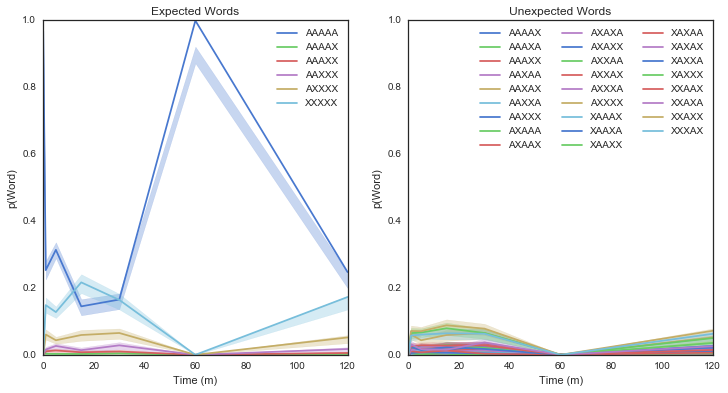

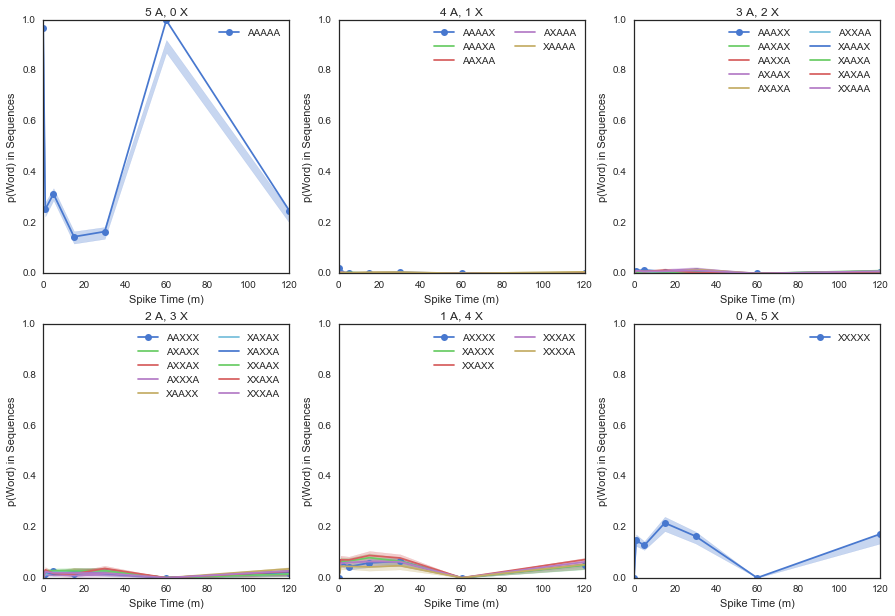

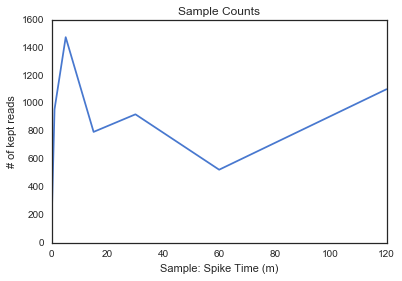

In [6]:
plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
plt.title('Expected Words')
for good_word in rev_good_words_5:
    h = plt.plot(rates_5_df.Time, rates_5_df[good_word])
    plt.fill_between(rates_5_df.Time, 
                     ci_5_df['%s_lb' % good_word], ci_5_df['%s_ub' % good_word], 
                     color=h[0].get_color(), alpha=0.3)

plt.legend()
plt.axis([0, 120, 0, 1])
plt.xlabel('Time (m)')
plt.ylabel('p(Word)')

plt.subplot(1,2,2)
plt.title('Unexpected Words')
for bad_word in bad_words_5:
    h = plt.plot(rates_5_df.Time, rates_5_df[bad_word])
    plt.fill_between(rates_5_df.Time, 
                     ci_5_df['%s_lb' % bad_word], ci_5_df['%s_ub' % bad_word], 
                     color=h[0].get_color(), alpha=0.3)

plt.legend(ncol=3)
plt.axis([0, 120, 0, 1])
plt.xlabel('Time (m)')
plt.ylabel('p(Word)')

plt.savefig('5site_good_bad.png')

plt.figure(figsize=[15,10])
for i in range(0,5+1):
    plt.subplot(2,3,6-i)
    plt.title('%i A, %i X' % (i, 5-i))
    for w in words_5:
        if w.count('A') == i:
            if w in rev_good_words_5:
                h = plt.plot(rates_5_df.Time, rates_5_df[w], 'o-')
            else:
                h = plt.plot(rates_5_df.Time, rates_5_df[w])
            plt.fill_between(rates_5_df.Time, 
                 ci_5_df['%s_lb' % w], ci_5_df['%s_ub' % w], 
                 color=h[0].get_color(), alpha=0.3)

    plt.legend(ncol=2)
    plt.axis([0, 120, 0, 1])
    plt.xlabel('Spike Time (m)')
    plt.ylabel('p(Word) in Sequences')
    
plt.savefig('5site_words.png')

plt.figure()
plt.title('Sample Counts')
plt.plot(rates_5_df.Time, counts_5_df[[c for c in counts_5_df.columns if c != 'Time']].sum(axis=1))
plt.xlabel('Sample: Spike Time (m)')
plt.ylabel('# of kept reads')

plt.show()

In [40]:
data_path = """D:/Google Drive/To File - Research Docs/Screening/nextgenAnalysis/Data/2016_05_18/v2/word_files/"""

word_f_range_5 = [79] + range(81, 85+1) + [80]
t_range = np.array([0, 1, 5, 15, 30, 60, 120])

data_5 = []
data_nodash_5 = []

for i in word_f_range_5:
    with open(data_path+'words_%i.txt' % i) as f:
        # Do full sequence loading
        data_5.append([line.strip() for line in f.readlines()])
        
        # Do no-dash, full extension stuff
        data_nodash_5.append([line for line in data_5[-1] if '-' not in line])

counts_5 = [get_nonrare_words(L) for L in data_nodash_5]
counts_5_df = pd.DataFrame()

counts_5_df['Time'] = t_range
for word in define_words(['A', 'X'], 5):
    counts_5_df[word] = [ct[word] for ct in counts_5]

rates_5_df = counts_5_df.div(counts_5_df[[c for c in counts_5_df.columns if c != 'Time']].sum(axis=1), axis=0)
rates_5_df.Time = counts_5_df.Time

ci_5_df = pd.DataFrame()
for w in words_5:
    lb, ub = proportion.proportion_confint(counts_5_df[w], counts_5_df.sum(axis=1))
    ci_5_df['%s_lb' % w] = lb
    ci_5_df['%s_ub' % w] = ub

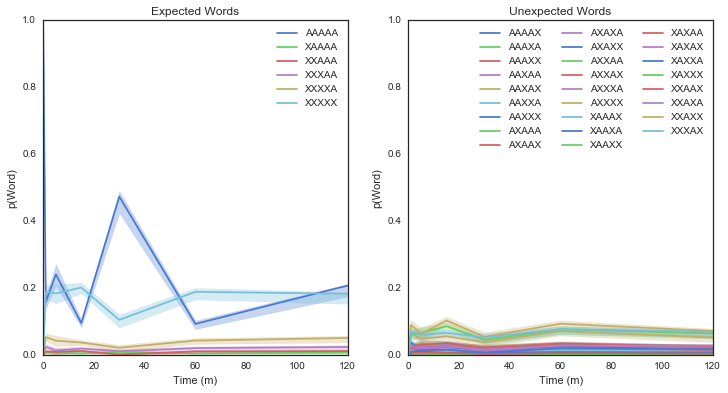

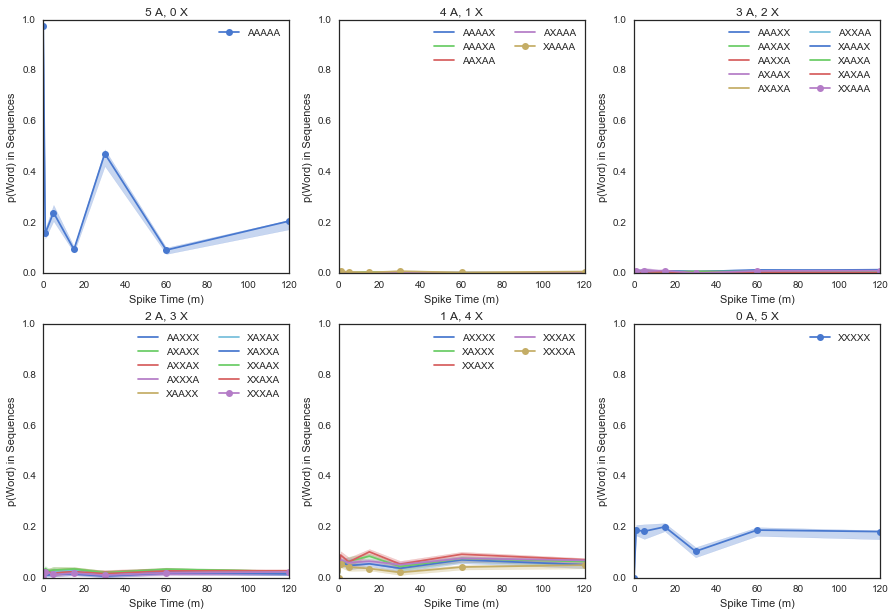

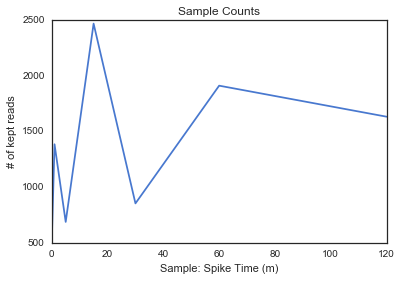

In [41]:
plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
plt.title('Expected Words')
for good_word in good_words_5:
    h = plt.plot(rates_5_df.Time, rates_5_df[good_word])
    plt.fill_between(rates_5_df.Time, 
                     ci_5_df['%s_lb' % good_word], ci_5_df['%s_ub' % good_word], 
                     color=h[0].get_color(), alpha=0.3)

plt.legend()
plt.axis([0, 120, 0, 1])
plt.xlabel('Time (m)')
plt.ylabel('p(Word)')

plt.subplot(1,2,2)
plt.title('Unexpected Words')
for bad_word in bad_words_5:
    h = plt.plot(rates_5_df.Time, rates_5_df[bad_word])
    plt.fill_between(rates_5_df.Time, 
                     ci_5_df['%s_lb' % bad_word], ci_5_df['%s_ub' % bad_word], 
                     color=h[0].get_color(), alpha=0.3)

plt.legend(ncol=3)
plt.axis([0, 120, 0, 1])
plt.xlabel('Time (m)')
plt.ylabel('p(Word)')

plt.savefig('5site_good_bad.png')

plt.figure(figsize=[15,10])
for i in range(0,5+1):
    plt.subplot(2,3,6-i)
    plt.title('%i A, %i X' % (i, 5-i))
    for w in words_5:
        if w.count('A') == i:
            if w in good_words_5:
                h = plt.plot(rates_5_df.Time, rates_5_df[w], 'o-')
            else:
                h = plt.plot(rates_5_df.Time, rates_5_df[w])
            plt.fill_between(rates_5_df.Time, 
                 ci_5_df['%s_lb' % w], ci_5_df['%s_ub' % w], 
                 color=h[0].get_color(), alpha=0.3)

    plt.legend(ncol=2)
    plt.axis([0, 120, 0, 1])
    plt.xlabel('Spike Time (m)')
    plt.ylabel('p(Word) in Sequences')
    
plt.savefig('5site_words.png')

plt.figure()
plt.title('Sample Counts')
plt.plot(rates_5_df.Time, counts_5_df[[c for c in counts_5_df.columns if c != 'Time']].sum(axis=1))
plt.xlabel('Sample: Spike Time (m)')
plt.ylabel('# of kept reads')

plt.show()

# Temperature Controls

In [25]:
def get_pos_cts(L, letter_order=['C','T','G','A','d']):
    n = len(L[0])
    cts = pd.DataFrame(np.zeros((n, len(letter_order))), columns=letter_order)
    
    for i in range(n):
        v = [w[i] for w in L]
        for c in letter_order:
            cts[c][i] = v.count(c)
    
    return cts    

In [26]:
data_path = """D:/Google Drive/To File - Research Docs/Screening/nextgenAnalysis/Data/2016_05_18/v2/del_word_files/"""

word_f_range_5 = range(64, 69+1)
sample_idx = ['Taq, 30C', 'Taq, 68C', 'Phi29, 30C', 'Phi29, 68C', 'Combo, 30C', 'Combo, 68C']

data_5 = []
data_nodash_5 = []

for i in word_f_range_5:
    with open(data_path+'words_del%i.txt' % i) as f:
        # Do full sequence loading
        data_5.append([line.strip() for line in f.readlines()])
        
        # Do no-dash, full extension stuff
        data_nodash_5.append([line for line in data_5[-1] if '-' not in line])

counts_5 = [get_nonrare_words(L) for L in data_nodash_5]
counts_5_df = pd.DataFrame()

for word in define_words(['A', 'X'], 5):
    counts_5_df[word] = [ct[word] for ct in counts_5]

rates_5_df = counts_5_df.div(counts_5_df[[c for c in counts_5_df.columns if c != 'Time']].sum(axis=1), axis=0)

ci_5_df = pd.DataFrame()
for w in words_5:
    lb, ub = proportion.proportion_confint(counts_5_df[w], counts_5_df.sum(axis=1))
    ci_5_df['%s_lb' % w] = lb
    ci_5_df['%s_ub' % w] = ub

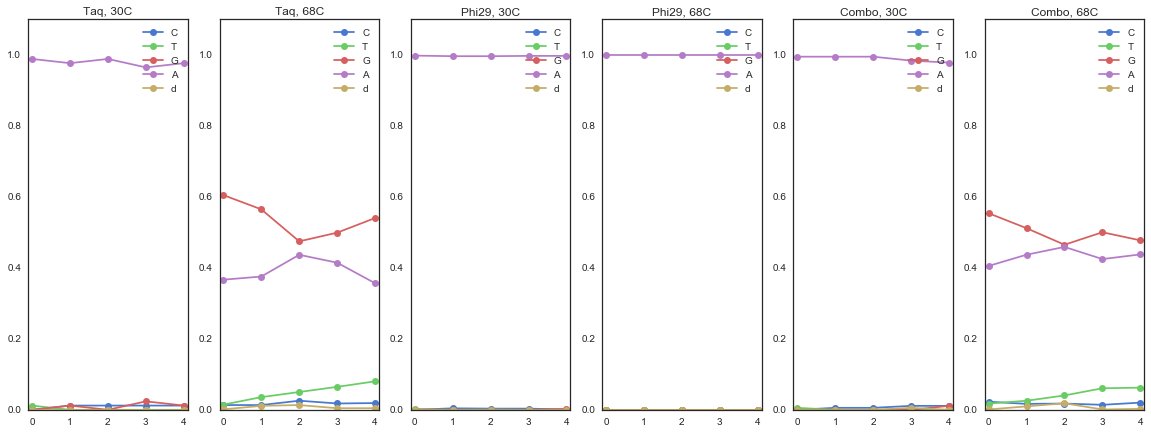

In [27]:
plt.figure(figsize=[20,7])
for i in range(len(data_nodash_5)):
    d = get_pos_cts(data_nodash_5[i])
    
    plt.subplot(1,6,i+1)
    for c in d.columns:
        plt.plot(d[c].div(d.sum(axis=1)), 'o-', label=c)
    plt.axis([-0.1, 4.1, 0, 1.1])
    plt.legend()
    plt.title(sample_idx[i])
    
plt.savefig('5site_locrate.png')
plt.show()

In [28]:
data_path = """D:/Google Drive/To File - Research Docs/Screening/nextgenAnalysis/Data/2016_05_18/v2/del_word_files/"""

word_f_range_5 = range(75, 80+1)
sample_idx = ['Taq, 30C', 'Taq, 68C', 'Phi29, 30C', 'Phi29, 68C', 'Combo, 30C', 'Combo, 68C']

data_5 = []
data_nodash_5 = []

for i in word_f_range_5:
    with open(data_path+'words_del%i.txt' % i) as f:
        # Do full sequence loading
        data_5.append([line.strip() for line in f.readlines()])
        
        # Do no-dash, full extension stuff
        data_nodash_5.append([line for line in data_5[-1] if '-' not in line])

counts_5 = [get_nonrare_words(L) for L in data_nodash_5]
counts_5_df = pd.DataFrame()

for word in define_words(['A', 'X'], 5):
    counts_5_df[word] = [ct[word] for ct in counts_5]

rates_5_df = counts_5_df.div(counts_5_df[[c for c in counts_5_df.columns if c != 'Time']].sum(axis=1), axis=0)

ci_5_df = pd.DataFrame()
for w in words_5:
    lb, ub = proportion.proportion_confint(counts_5_df[w], counts_5_df.sum(axis=1))
    ci_5_df['%s_lb' % w] = lb
    ci_5_df['%s_ub' % w] = ub

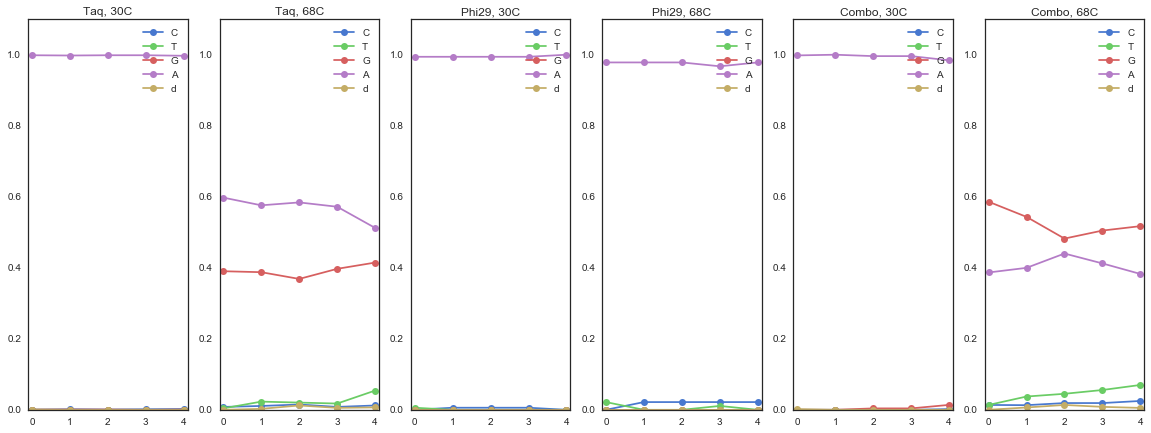

In [29]:
plt.figure(figsize=[20,7])
for i in range(len(data_nodash_5)):
    d = get_pos_cts(data_nodash_5[i])
    
    plt.subplot(1,6,i+1)
    for c in d.columns:
        plt.plot(d[c].div(d.sum(axis=1)), 'o-', label=c)
    plt.axis([-0.1, 4.1, 0, 1.1])
    plt.legend()
    plt.title(sample_idx[i])
    
plt.savefig('5site_locrate.png')
plt.show()

# Look at aggregate behavior of long-incubation 5-site

In [30]:
data_path = """D:/Google Drive/To File - Research Docs/Screening/nextgenAnalysis/Data/2016_05_18/v2/del_word_files/"""

word_f_range_5 = range(56, 63+1)
t_range = np.array([0, 0.5, 1, 2, 3, 4, 6, 7])
sample_idx = ['%sh dA Spike' % str(x) for x in t_range]

data_5 = []
data_nodash_5 = []

for i in word_f_range_5:
    with open(data_path+'words_del%i.txt' % i) as f:
        # Do full sequence loading
        data_5.append([line.strip() for line in f.readlines()])
        
        # Do no-dash, full extension stuff
        data_nodash_5.append([line for line in data_5[-1] if '-' not in line])

counts_5 = [get_nonrare_words(L) for L in data_nodash_5]
counts_5_df = pd.DataFrame()

counts_5_df['Time'] = t_range
for word in define_words(['A', 'X'], 5):
    counts_5_df[word] = [ct[word] for ct in counts_5]

rates_5_df = counts_5_df.div(counts_5_df[[c for c in counts_5_df.columns if c != 'Time']].sum(axis=1), axis=0)
rates_5_df.Time = counts_5_df.Time

ci_5_df = pd.DataFrame()
for w in words_5:
    lb, ub = proportion.proportion_confint(counts_5_df[w], counts_5_df.sum(axis=1))
    ci_5_df['%s_lb' % w] = lb
    ci_5_df['%s_ub' % w] = ub

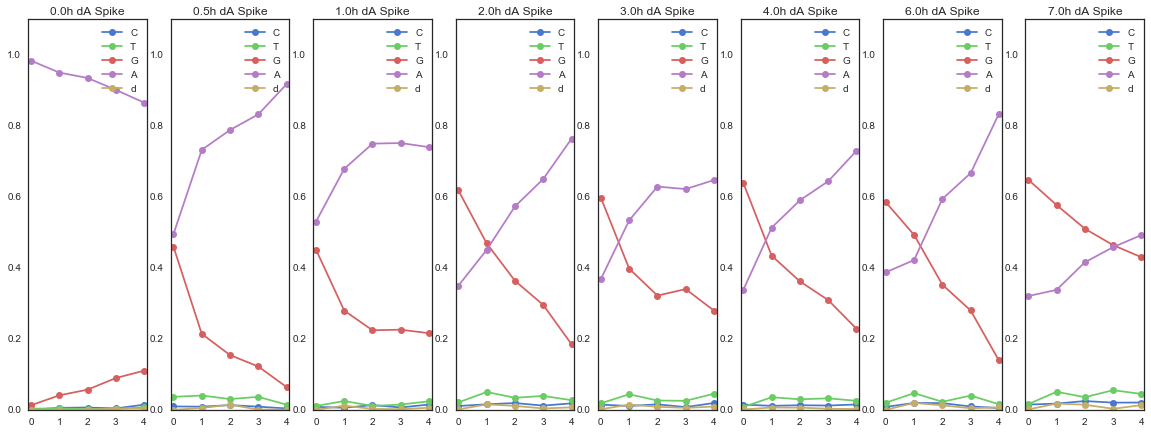

In [31]:
plt.figure(figsize=[20,7])
for i in range(len(data_nodash_5)):
    d = get_pos_cts(data_nodash_5[i])
    
    plt.subplot(1,8,i+1)
    for c in d.columns:
        plt.plot(d[c].div(d.sum(axis=1)), 'o-', label=c)
    plt.axis([-0.1, 4.1, 0, 1.1])
    plt.legend()
    plt.title(sample_idx[i])
    
plt.savefig('5site_locrate.png')
plt.show()

## Now, just the deletions

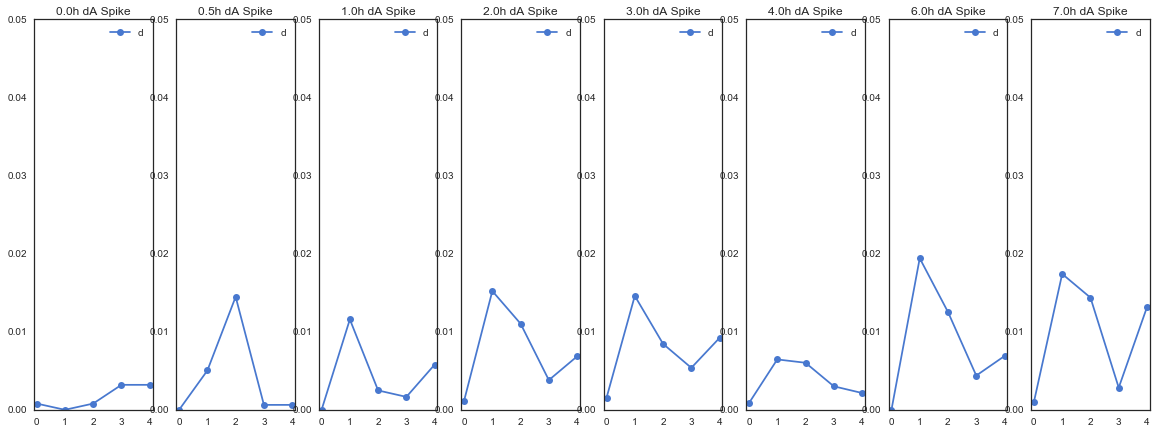

In [33]:
plt.figure(figsize=[20,7])
for i in range(len(data_nodash_5)):
    d = get_pos_cts(data_nodash_5[i])
    
    plt.subplot(1,8,i+1)
    plt.plot(d['d'].div(d.sum(axis=1)), 'o-', label=c)
    plt.axis([-0.1, 4.1, 0, 0.05])
    plt.legend()
    plt.title(sample_idx[i])
    
plt.savefig('5site_locrate.png')
plt.show()